In [14]:
import copy
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import skimage.data
import skimage.transform

# TODO: figure out a better way of doing this
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
# import register
import utils



[1.  1.  0.1 0.  0.  0. ] 0.07886392320100759
[0.7604059194775631, 0.755923217722588, 0.7873307411724813, 0.7886357115184748, 0.7886720581519078, 0.7887358584016966]
[1.05 1.   0.1  0.   0.   0.  ] 0.07749046643709144
[0.7450960784365853, 0.7387533325258161, 0.7667190786154862, 0.7677887513031256, 0.7748889334094381, 0.7749838718895132]
[1.   1.05 0.1  0.   0.   0.  ] 0.07718322040396297
[0.7399943992906735, 0.7433114583446074, 0.7711750967472945, 0.7712916349176591, 0.7718619972219315, 0.7719486104715707]
[1.    1.    0.105 0.    0.    0.   ] 0.07884725822015086
[0.7589154965596706, 0.7560465868076675, 0.7875087667264298, 0.7886266936215065, 0.7885208833403234, 0.7885679752689726]
[1.0e+00 1.0e+00 1.0e-01 2.5e-04 0.0e+00 0.0e+00] 0.07886329972352085
[0.7603609330037392, 0.7559185726054426, 0.7873342608917653, 0.7886502368243212, 0.7886662394697488, 0.7887298433635812]
[1.0e+00 1.0e+00 1.0e-01 0.0e+00 2.5e-04 0.0e+00] 0.07886393040770748
[0.7604057233311908, 0.7559232914359687, 0.78733

[ 1.52075275e+00  1.43506459e+00  9.94995858e-02  7.23239210e-04
 -4.74416022e-04 -2.04625925e-03] 0.05638736783666698
[0.6223052973048029, 0.5664241909639366, 0.5256422864408632, 0.5198385670613667, 0.5638169916954339, 0.5640648758860543]
[ 1.61512186e+00  1.43406714e+00  9.61032598e-02  8.49786947e-04
 -7.02098634e-04 -2.12945322e-03] 0.061964098553871534
[0.7041402215112975, 0.6324513644106631, 0.6206736263508004, 0.6042493823411371, 0.619703645891981, 0.6198419380661652]
[ 1.41078111e+00  1.30934459e+00  9.53331614e-02  5.84741357e-04
 -3.63258045e-04 -1.50118475e-03] 0.05701677873052302
[0.5905765566160615, 0.5384418688265964, 0.5133784499691938, 0.506760491487089, 0.5700108439798957, 0.570252067118806]
[ 1.40612023e+00  1.34936948e+00  9.90238588e-02  6.22674816e-04
 -5.33890306e-04 -1.56500369e-03] 0.05522350632706697
[0.5745944662550585, 0.5266317739097905, 0.4885715986771044, 0.484918162643446, 0.5520637654936705, 0.5523534822168802]
[ 1.35095677e+00  1.35321062e+00  1.0206069

[ 1.41216089e+00  1.55798461e+00  1.27818720e-01  1.65632033e-04
 -7.19703044e-04 -1.55337790e-03] 0.048816492312539254
[0.537406752152136, 0.5200451629674427, 0.35537813681355873, 0.41632863231182415, 0.4879008018520768, 0.4882270574454303]
[ 1.35447360e+00  1.53636550e+00  1.31224393e-01  1.84658317e-05
 -8.32019512e-04 -1.09583489e-03] 0.04782751628141075
[0.4999686560159153, 0.49602911670169464, 0.3084939566511019, 0.3746349953102447, 0.47801526300919583, 0.4783612710937531]
[ 1.32516307e+00  1.61092250e+00  1.37326928e-01 -1.12973547e-04
 -7.80729259e-04 -1.46330273e-03] 0.04825704912938505
[0.49350409554351443, 0.5241456194021759, 0.2614826925756031, 0.35663447793622083, 0.4822452828579847, 0.48260113653988285]
[ 1.32891309e+00  1.58829434e+00  1.44900884e-01 -7.72047325e-05
 -8.15511496e-04 -1.09799748e-03] 0.046433402771758794
[0.4777712573583252, 0.4981920380391714, 0.23976399084392502, 0.33803560372021385, 0.4640187473810865, 0.4643863371833]
[ 1.30156562e+00  1.60367483e+00 

[ 1.34594312  1.56483541  0.31228953 -0.00245929 -0.00161602  0.00224103] 0.01461193850020946
[0.3278001242599103, 0.18788825030753817, 0.3935735195226834, 0.3278940489328541, 0.14612229414335465, 0.14616020251412684]
[ 1.31593765  1.56187859  0.36707019 -0.00330482 -0.00189308  0.0036488 ] 0.025885326608184697
[0.3155180853960324, 0.30724303709104733, 0.4902640917588281, 0.43483137652337595, 0.2589314514853585, 0.25905646532538834]
[ 1.27055975e+00  1.60519219e+00  2.70584881e-01 -2.17554361e-03
 -1.54005468e-03  1.75330193e-03] 0.014034274378558975
[0.22125058808696044, 0.22024967903476303, 0.2771062382775673, 0.22754781649609715, 0.1404963502327524, 0.14027286560007546]
[ 1.265977    1.60920957  0.36948933 -0.00368296 -0.00202926  0.00372762] 0.027314527580088246
[0.29129799746037494, 0.3431312535704491, 0.4760635525703245, 0.4262252208558232, 0.27329692056975974, 0.27315192392334375]
[ 1.28900857e+00  1.58769416e+00  2.75859230e-01 -2.12795361e-03
 -1.51956199e-03  1.84713693e-03] 

[ 1.29440478  1.59446418  0.29928573 -0.00252456 -0.00163507  0.00230523] 0.0012764603774684977
[0.21671748490636097, 0.15778909569904245, 0.3522201783640482, 0.27747122154988174, 0.013122984885749993, 0.01291606988679508]
[ 1.28764438e+00  1.61026665e+00  2.93347700e-01 -2.44782854e-03
 -1.60866126e-03  2.15588215e-03] 0.004348577943163185
[0.21029899994366555, 0.18966093181537821, 0.3407654037597422, 0.2650740954123899, 0.04379883491521153, 0.043534114754030954]
[ 1.30532527  1.59826193  0.30303308 -0.00252741 -0.00163359  0.00230141] 0.0006932025810939713
[0.233582861565746, 0.16280739893899257, 0.36436355087953537, 0.2855495415730319, 0.006866220508207193, 0.0068861417128855745]
[ 1.29320466  1.58350321  0.29774061 -0.0025944  -0.00167951  0.00244843] 0.003326357146804836
[0.2258502692155961, 0.1420316523834057, 0.3462997513948861, 0.2780856118805857, 0.033628551363717125, 0.033241750796408516]
[ 1.30248262  1.6073758   0.30105496 -0.00247663 -0.00160989  0.00220089] 0.000877741947

[ 1.2997367   1.6000289   0.30148604 -0.00251245 -0.00163256  0.00227916] 8.170902994832069e-05
[0.22300715926227055, 0.1621650822875308, 0.3597266747408357, 0.2808993855557399, 0.0010156352139728544, 0.0008944253134409287]
[ 1.3016263   1.59930119  0.30157236 -0.00251414 -0.001632    0.00227879] 0.00013911503975049617
[0.22665452756248555, 0.16075751449290418, 0.36021005714503423, 0.28148811542089014, 0.0015358294039246466, 0.001440987713987075]
[ 1.29969395  1.60060262  0.30236621 -0.00252476 -0.00163677  0.00229457] 7.768027440884398e-05
[0.2227713227984319, 0.16388278977293655, 0.36187966899944723, 0.2826767487484891, 0.0008870638211671673, 0.0008093491446669195]
[ 1.29904859  1.60112209  0.30142574 -0.00252442 -0.00163554  0.00229225] 0.00013003566343977276
[0.2217545641599331, 0.16419264840886405, 0.35968086016116785, 0.2803532489549697, 0.001522642929750968, 0.0013871555407380888]
[ 1.30062026  1.59995225  0.30236241 -0.00252088 -0.00163537  0.00228938] 7.39991025320973e-05
[0.2

[ 1.30012484  1.60016269  0.30208912 -0.00252167 -0.00163544  0.00229043] 6.080440634842655e-05
[0.22362095462460202, 0.1627541446519143, 0.3612420077801394, 0.2822301018251243, 0.0007375375469818577, 0.0006491857306856626]
[ 1.29973493  1.60009806  0.30201099 -0.00252197 -0.00163581  0.00229125] 6.427563028198957e-05
[0.22290079397285492, 0.16272772345360584, 0.36094850015648855, 0.2820361622740967, 0.0007899538921709347, 0.0006939734185721882]
[ 1.30021721  1.60008147  0.30203572 -0.0025198  -0.00163455  0.00228807] 6.058913261063134e-05
[0.22380765029515637, 0.1625474347749172, 0.36112365678058705, 0.28214724734309515, 0.0007384495919823733, 0.0006486534976310436]
[ 1.3001981   1.60025508  0.30214063 -0.00252083 -0.00163528  0.00228956] 6.183511744065077e-05
[0.2237483438219859, 0.162927390256146, 0.3614040527161259, 0.2823278388086726, 0.0007404198913452242, 0.00065548568420977]
[ 1.30004233  1.60003344  0.30199366 -0.0025203  -0.00163479  0.0022888 ] 6.063321669512634e-05
[0.22348

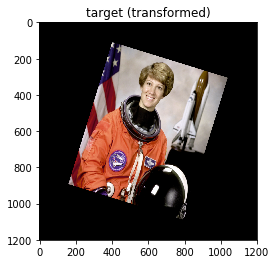

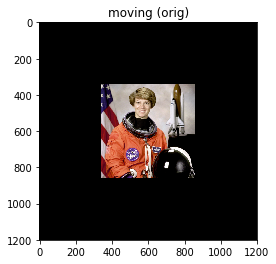

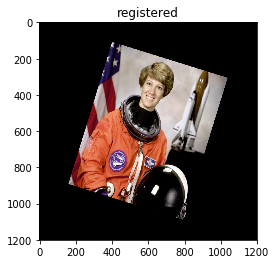

In [17]:
im = skimage.data.astronaut()

def apply_affine_tform(params, im):
    scale_x, scale_y, rotation, shear, trans_x, trans_y = params
    
    # re-initialize bad scales
    if scale_x < 0:
        scale_x = [np.abs(np.random.randn())]
        print(scale_x)
    if scale_x < 0:
        scale_x = [np.abs(np.random.randn())]
        print(scale_x)

    moving_tfm = skimage.transform.AffineTransform(
        scale=(scale_x, scale_y),
        rotation=rotation,
        shear=shear,
        translation=(trans_x, trans_y))

    return utils.apply_matrix_tform(im, moving_tfm)
    
def ssd_affine_partial_deriv(params, im_fixed, im_moving, im_pad_size,
               show_figs=False, delta=.1, scale=[1]):
    """SSD is calculated between im_fixed and transformed moving image.

    TODO (nripesh): calculate gradient (numeric or mathematical)
    TODO : callbacks to view progress as images?
    TODO: how to calculate scale - is it simply based on the 
          ratio of the range of params?
    """
    # get individual params
    im_moving_regis = apply_affine_tform(params, im_moving)
    
    row, col, channel = im_moving_regis.shape
    ssd = np.sum(np.square(im_fixed - im_moving_regis)) / (
        row * col * channel)
    
    # 
    if len(scale) == 1:
        scale = scale * len(params)
    
    grad = []
    for i in range(len(params)):
        params_i = copy.deepcopy(params)
        params_i[i] += delta * scale[i]
        
        im_moving_regis_i = apply_affine_tform(params_i, im_moving)
        ssd_i = np.sum(np.square(im_fixed - im_moving_regis_i)) / (
            row * col * channel)
        grad.append(ssd_i / delta)
   
    #     print('scale_x: {:2.2f}, scale_y: {:2.2f}, rotation: {:2.2f}, '.format(
    #         scale_x, scale_y, rotation) +
    #           'shear: {:2.2f}, t_x: {:2.2f}, t_y: {:2.2f}, SSD: {:2.3f}'.format(
    #         shear, trans_x, trans_y, ssd))
    print(params, ssd)
    print(grad)

    if show_figs:
        plt.figure(1)
        plt.title('target (transformed)')
        plt.imshow(im_fixed)
        plt.figure(2)
        plt.title('moving (orig)')
        plt.imshow(im_moving)
        plt.figure(3)
        plt.title('registered')
        plt.imshow(im_moving_regis)
        plt.show()

    return ssd

def im_register_affine(im_fixed, im_moving,
                       pad_size=None, options={}, show_figs=False):
    """For registering using affine transformation.
    """
    if pad_size is None:
        pad_size = (int(im_moving.shape[0] * 2),
                    int(im_moving.shape[1] * 2))

    orig_size = (im_moving.shape[0], im_moving.shape[1])

    im_fixed = utils.resize_image(im_fixed, pad_size)
    im_moving = utils.resize_image(im_moving, pad_size) / 255

    im_f_shape = im_fixed.shape
    im_m_shape = im_moving.shape

    assert im_f_shape == im_m_shape

    # random initialization and assignment
    init_scale = (1., 1.)
    init_rotation = .1
    init_shear = 0.0
    init_translation = (0, 0)
    params_init = (init_scale[0], init_scale[1], init_rotation,
                   init_shear, init_translation[0], init_translation[1])
    
    error_function = lambda x: ssd_affine_partial_deriv(
        x, im_fixed, im_moving, pad_size, show_figs=show_figs)
    
    affine_optimized = scipy.optimize.minimize(
        error_function, params_init, method='Nelder-Mead',
        options=options, jac=False)

    # apply solved registration
    regis_tfm = skimage.transform.AffineTransform(
        scale=(affine_optimized.x[0], affine_optimized.x[1]),
        rotation=affine_optimized.x[2],
        shear=affine_optimized.x[3],
        translation=(affine_optimized.x[4], affine_optimized.x[5]))
    
    im_registered = utils.apply_matrix_tform(
            im_moving, regis_tfm)

    return utils.resize_image(im_registered, orig_size)

# initialization
true_scale = (1.3, 1.6)
true_rotation = .3
true_shear = 0
true_translation = (0, 0)

aff_tfm = skimage.transform.AffineTransform(
    scale=true_scale,
    rotation=true_rotation,
    shear=true_shear,
    translation=true_translation)

PADDED_IM_SIZE = (1200, 1200) 
im_fixed = utils.apply_matrix_tform(
    utils.resize_image(im, PADDED_IM_SIZE), aff_tfm)
im_moving = utils.resize_image(im, PADDED_IM_SIZE)


im_registered = im_register_affine(
    im_fixed, im_moving, pad_size=PADDED_IM_SIZE,
    options={'maxiter': 200}, show_figs=False)

plt.figure(1)
plt.title('target (transformed)')
plt.imshow(im_fixed)
plt.figure(2)
plt.title('moving (orig)')
plt.imshow(im_moving)
plt.figure(3)
plt.title('registered')
plt.imshow(im_registered)
plt.show()